In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model, Model

from tensorflow.keras.layers import Input

from sklearn.preprocessing import LabelEncoder

In [ ]:
# Directory paths
train_data_dir = '/content/drive/MyDrive/1. FHNW Classes/2nd Semester/3. Applied Computational Intelligence/Proyecto/brain_tumor/Training'
test_data_dir = '/content/drive/MyDrive/1. FHNW Classes/2nd Semester/3. Applied Computational Intelligence/Proyecto/brain_tumor/Testing'

In [ ]:
def count_images(data_dir):
    categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
    counts = {}
    for category in categories:
        # Construct the full path to the category directory
        category_dir = os.path.join(data_dir, category)
        # List all files in this directory and count them
        num_files = len([name for name in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, name))])
        counts[category] = num_files
    return counts

In [ ]:
# Count images in each category
train_counts = count_images(train_data_dir)
test_counts = count_images(test_data_dir)

print("Training Data Counts:")
for category, count in train_counts.items():
    print(f"{category}: {count}")

print("\nTesting Data Counts:")
for category, count in test_counts.items():
    print(f"{category}: {count}")

Training Data Counts:
glioma: 1321
meningioma: 1339
notumor: 1595
pituitary: 1457

Testing Data Counts:
glioma: 300
meningioma: 306
notumor: 405
pituitary: 300


In [ ]:
# Extract files and labels
def extract_files_labels(directory):
    filepaths = []
    labels = []
    for fold in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, fold)):
            foldpath = os.path.join(directory, fold)
            for file in os.listdir(foldpath):
                filepaths.append(os.path.join(foldpath, file))
                labels.append(fold)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

In [ ]:
# Load data and preprocess
train_df = extract_files_labels(train_data_dir)
test_df = extract_files_labels(test_data_dir)

# Data Generators
batch_size = 16
img_size = (224, 224)

# Configuration
datagen_train = ImageDataGenerator(preprocessing_function=preprocess_input)
datagen_test = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen_train.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                        target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=True)
test_gen = datagen_test.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [ ]:
# Encode labels as numbers
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_gen.classes)
test_labels = label_encoder.transform(test_gen.classes)

In [ ]:
# Load your custom pretrained EfficientNet B0 model
model_path = '/content/drive/MyDrive/1. FHNW Classes/2nd Semester/3. Applied Computational Intelligence/Proyecto/CODIGO BUENO/model_enb0.h5'
pretrained_model = load_model(model_path)
pretrained_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1

In [ ]:
# Directly use the pretrained model as the feature extractor, assuming no further modification is needed
feature_extractor = Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[2].output)

In [ ]:
# Use the existing input
model_input = pretrained_model.input

# Get the output from the 'flatten' layer
model_output = pretrained_model.layers[2].output  # '2' is the index of the flatten layer

In [ ]:
# Create a new model that includes up to the flatten layer
feature_extractor = Model(inputs=model_input, outputs=model_output)
feature_extractor.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0_input (Inpu  [(None, 224, 224, 3)]     0         
 tLayer)                                                         
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
Total params: 4054691 (15.47 MB)
Trainable params: 4010108 (15.30 MB)
Non-trainable params: 44583 (174.16 KB)
_______________

In [ ]:
# Feature Extraction
feature_extractor = Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[2].output)
train_features = feature_extractor.predict(train_gen, steps=np.ceil(len(train_df)/batch_size))
test_features = feature_extractor.predict(test_gen, steps=np.ceil(len(test_df)/batch_size))

print("Training features shape:", train_features.shape)
print("Testing features shape:", test_features.shape)

82/82 [==============================] - 352s 4s/step
Training features shape: (5712, 1280)
Testing features shape: (1311, 1280)


In [ ]:
print("Training features shape:", train_features.shape)
print("Testing features shape:", test_features.shape)

# Statistical Analysis of Features
print("Training Features Statistics:")
print("Mean:", np.mean(train_features, axis=0))
print("Standard Deviation:", np.std(train_features, axis=0))
print("Minimum:", np.min(train_features, axis=0))
print("Maximum:", np.max(train_features, axis=0))

Training features shape: (5712, 1280)
Testing features shape: (1311, 1280)
Training Features Statistics:
Mean: [-0.11656585  0.23255907 -0.14133577 ...  0.15662858 -0.06880158
  0.09260204]
Standard Deviation: [0.96392864 1.2182173  0.98589736 ... 1.0902002  1.0681857  1.1265943 ]
Minimum: [-1.2911255 -1.2186419 -1.0957416 ... -1.3444859 -1.2476581 -1.1660359]
Maximum: [5.3714786 8.371137  4.6138563 ... 6.74444   6.7246075 9.467535 ]


In [ ]:
# Feature Scaling
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Statistical Analysis of Features
print("Training Features Scaled Statistics:")
print("Mean Scaled:", np.mean(train_features_scaled, axis=0))
print("Standard Deviation Scaled:", np.std(train_features_scaled, axis=0))
print("Minimum Scaled:", np.min(train_features_scaled, axis=0))
print("Maximum Scaled:", np.max(train_features_scaled, axis=0))

Training Features Scaled Statistics:
Mean Scaled: [ 5.0087938e-09  1.7822957e-08 -5.8331575e-09 ...  1.0351507e-08
  3.8557277e-09 -1.2939384e-08]
Standard Deviation Scaled: [1.        1.000001  1.000001  ... 1.        1.0000007 1.0000006]
Minimum Scaled: [-1.2185137 -1.1912496 -0.9680585 ... -1.3769158 -1.1036049 -1.1172066]
Maximum Scaled: [5.6934137 6.680728  4.8232126 ... 6.042753  6.3597555 8.3214855]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5712 samples in 0.015s...
[t-SNE] Computed neighbors for 5712 samples in 6.677s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5712
[t-SNE] Computed conditional probabilities for sample 2000 / 5712
[t-SNE] Computed conditional probabilities for sample 3000 / 5712
[t-SNE] Computed conditional probabilities for sample 4000 / 5712
[t-SNE] Computed conditional probabilities for sample 5000 / 5712
[t-SNE] Computed conditional probabilities for sample 5712 / 5712
[t-SNE] Mean sigma: 12.061726
[CV 1/5] END ..C=0.1, gamma=auto, kernel=linear;, score=0.255 total time= 1.7min
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.273376
[t-SNE] KL divergence after 300 iterations: 2.226408


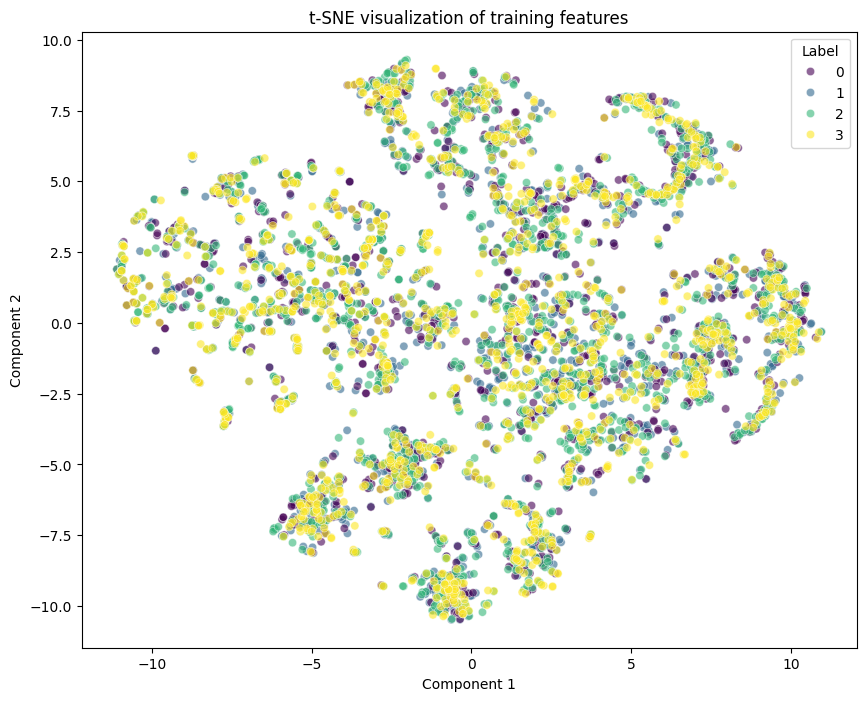

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Apply t-SNE to reduce dimensions
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
train_tsne_features = tsne.fit_transform(train_features_scaled)

# Prepare DataFrame for visualization
tsne_df = pd.DataFrame({
    'Component 1': train_tsne_features[:, 0],
    'Component 2': train_tsne_features[:, 1],
    'Label': label_encoder.inverse_transform(train_labels)
})

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Component 1', y='Component 2', hue='Label', palette='viridis', data=tsne_df, legend="full", alpha=0.6)
plt.title('t-SNE visualization of training features')
plt.show()

In [ ]:
from joblib import parallel_backend

In [ ]:
# Define parameter grid

# SVM Classifier
param_grid = {
    'C': [1, 10, 100],  # Exploring higher regularization strengths
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Various scales of gamma
    'kernel': ['rbf']  # Focusing on the RBF kernel
}

# Create SVM classifier & runninng a grid search with cross-validation
svm_classifier = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=5, verbose=4, n_jobs=-1)

# Threading backend to avoid fork issues
with parallel_backend('threading', verbose=4, n_jobs=1):
    svm_classifier.fit(train_features_scaled, train_labels)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.234 total time= 1.6min
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.246 total time= 1.7min
[CV 3/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.261 total time= 1.6min
[CV 4/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.238 total time= 1.6min
[CV 5/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.264 total time= 1.6min
[CV 1/5] END .......C=1, gamma=auto, kernel=rbf;, score=0.234 total time= 1.6min
[CV 3/5] END .......C=1, gamma=auto, kernel=rbf;, score=0.261 total time= 1.6min
[CV 2/5] END .......C=1, gamma=auto, kernel=rbf;, score=0.246 total time= 1.6min
[CV 5/5] END .......C=1, gamma=auto, kernel=rbf;, score=0.264 total time= 1.6min
[CV 4/5] END .......C=1, gamma=auto, kernel=rbf;, score=0.238 total time= 1.7min
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.257 total time= 1.6min
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.246 total time= 1.6min
[CV 3/5] END .......C=1, gam

[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 17.6min


[CV 2/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.252 total time= 1.6min
[CV 3/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.257 total time= 1.6min
[CV 4/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.282 total time= 1.6min
[CV 5/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.272 total time= 1.6min
[CV 1/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.229 total time= 1.7min
[CV 2/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.236 total time= 1.6min
[CV 3/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.250 total time= 1.5min
[CV 4/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.244 total time= 1.6min
[CV 5/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.240 total time= 1.6min
[CV 1/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.229 total time= 1.6min
[CV 2/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.236 total time= 1.6min
[CV 3/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.250 total time= 1.6min
[CV 4/5] END ......C=10, gam

[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 60.6min finished


In [ ]:
# Evaluate the best parameters and the best score
print("Best parameters:", svm_classifier.best_params_)
print("Best cross-validation score: {:.2f}".format(svm_classifier.best_score_))

Best parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best cross-validation score: 0.28


In [ ]:
# Evaluate
train_predictions = svm_classifier.predict(train_features_scaled)
test_predictions = svm_classifier.predict(test_features_scaled)

train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9758
Test Accuracy: 0.2670


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
import itertools

In [ ]:
macro_f1 = f1_score(test_labels, test_predictions, average='macro')
print("Macro-averaged F1 score: {:.4f}".format(macro_f1))

Macro-averaged F1 score: 0.1397


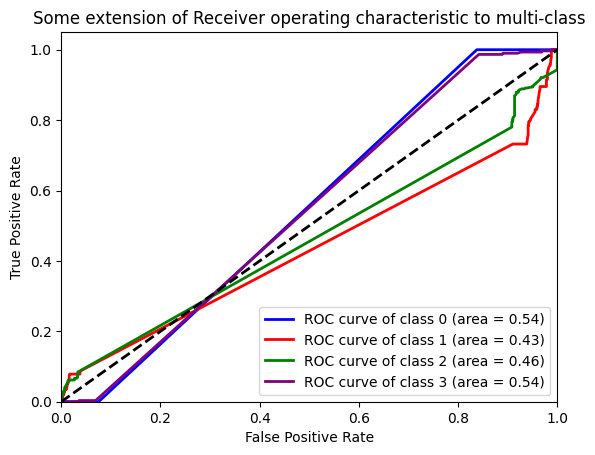

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the labels for ROC
y_bin = label_binarize(test_labels, classes=[0, 1, 2, 3])
n_classes = y_bin.shape[1]

# Learn to predict each class against the other
y_score = svm_classifier.decision_function(test_features_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['blue', 'red', 'green', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print("Number of support vectors for each class:", svm_classifier.best_estimator_.n_support_)
print("Support vectors themselves:", svm_classifier.best_estimator_.support_vectors_)

Number of support vectors for each class: [1312 1332 1579 1444]
Support vectors themselves: [[-1.18 -1.16 -0.94 ...  0.62 -0.13 -0.56]
 [-0.65  0.37 -0.66 ... -0.11 -0.5   0.45]
 [-0.01 -1.09 -0.94 ... -0.64 -0.78 -0.38]
 ...
 [ 1.43  0.09  1.06 ... -0.39  0.18 -0.94]
 [-0.11 -0.49 -0.94 ... -0.78 -0.07 -0.79]
 [ 1.42  2.07 -0.94 ...  3.58 -0.43  4.14]]


Confusion matrix, without normalization
[[  0   0 300   0]
 [ 30  24 228  24]
 [ 28  24 325  28]
 [  1   1 297   1]]


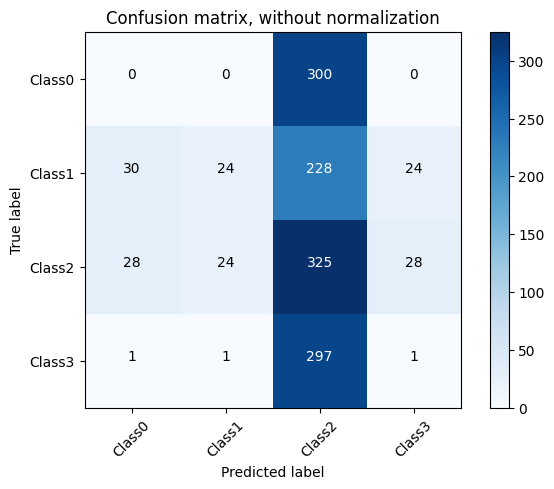

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels, test_predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Class0', 'Class1', 'Class2', 'Class3'],
                      title='Confusion matrix, without normalization')
plt.show()